In [444]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import pearsonr
from optimalEmbedding_sampling import run_optEmbedding_sampling
from GCCM_sampling import run_GCCM_sampling
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
from plot import get_mean, get_interval, make_Eplot, make_Lplot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set specific font sizes
plt.rcParams.update({
    'font.size': 12,          # Global font size
    'axes.titlesize': 11,     # Title font size
    'axes.labelsize': 11,     # X and Y axis labels font size
    'xtick.labelsize': 9,    # X-axis tick labels font size
    'ytick.labelsize': 9,    # Y-axis tick labels font size
    'legend.fontsize': 10,    # Legend font size
})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Reaction-diffusion systems

In [6]:
def laplacian(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright - 4 * Zcenter) / dx**2

In [7]:
def show_patterns(U, ax=None):
    ax.imshow(U, cmap=plt.cm.viridis,
              interpolation='None')
           # extent=[-1, 1, -1, 1])
    ax.set_axis_off()

$$ \frac{\partial x}{\partial t} = \alpha_1 \Delta x - x^2 $$

$$ \frac{\partial y}{\partial t} = \alpha_2 \Delta y - y^2 + c~xy $$

- versions
- T: steady state T=100 vs t=10/20
- a: diffusion constants
- P: correlation as indicator for coupling
- initialization
- delay

## X -> Y

In [140]:
def run_sim(X_in, Y_in, T, c, a1, a2, saveas=False):
    X = X_in.copy()
    Y = Y_in.copy()
    
    dt = .001  # time step, 
    n = int(T / dt)  # number of iterations

    fig, axes = plt.subplots(2,8, figsize=(6.3, 2))
    step_plot = n // 8
    # We simulate the PDE with the finite difference
    # method.
    for i in range(n):
        # We compute the Laplacian of u and v.
        deltaX = laplacian(X)
        deltaY = laplacian(Y)
        # We take the values of u and v inside the grid.
        Xc = X[1:-1, 1:-1]
        Yc = Y[1:-1, 1:-1]
        
        # We update the variables.
        X[1:-1, 1:-1], Y[1:-1, 1:-1] = \
            Xc + dt * (a1 * deltaX - Xc**2),\
            Yc + dt * (a2 * deltaY - Yc**2 + c * Xc * Yc)
        
        # Neumann conditions: derivatives at the edges
        # are null.
        for B in (X, Y):
            B[0, :] = B[1, :]
            B[-1, :] = B[-2, :]
            B[:, 0] = B[:, 1]
            B[:, -1] = B[:, -2]
    
        # We plot the state of the system at
        # 9 different times.
        if i % step_plot == 0 and i < 8 * step_plot:
            ax1 = axes[0, i // step_plot]
            ax2 = axes[1, i // step_plot]
            
            show_patterns(X, ax=ax1)
            ax1.set_title(f'${i * dt:.0f}$')
            show_patterns(Y, ax=ax2)
            #ax.set_title(f'Y $t={i * dt:.0f}$')
            if i // step_plot == 0:
                ax1.text(-0.25, 0.5, 'X', transform=ax1.transAxes, fontsize=11, horizontalalignment='center')
                ax2.text(-0.25, 0.5, 'Y', transform=ax2.transAxes, fontsize=11, horizontalalignment='center')
                
    plt.tight_layout()
    if saveas:
        plt.savefig('plots/diffusion/'+saveas, bbox_inches='tight')
    return X, Y

## Parameters

In [9]:
dims = np.arange(1,9)
lib_sizes = np.arange(10,101,30)
lib_size = 100

In [533]:
size = 100  # size of the 2D grid
dx = 2. / size  # space step
a1 = 2.8e-4 # 5e-3
a2 = 2.8e-4
T_a = dx**2*size**2/a1
T_a

14285.714285714286

In [12]:
X_rand = np.random.rand(size, size)
Y_rand = np.random.rand(size, size)
results_random = run_optEmbedding_sampling(X_rand, Y_rand, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


# Version 1

In [13]:
np.random.seed(seed=3)
X_rand = np.random.rand(size, size)
Y_rand = np.random.rand(size, size)

### no coupling

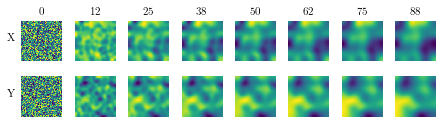

In [64]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0, a1=a1, a2=a2, saveas='v1_c00_sim100.pdf')

In [65]:
correlation_coefficient, p_value = pearsonr(X.flatten(), Y.flatten())
correlation_coefficient, p_value 
# Essentially, this means that changes in the pixel values of one image are not strongly associated with 
#changes in the pixel values of the other image.

(-0.08727308622763383, 2.2719634010978448e-18)

In [44]:
results_0 = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [67]:
results_0_L = run_GCCM_sampling(X, Y, lib_sizes, E=6, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


### weak

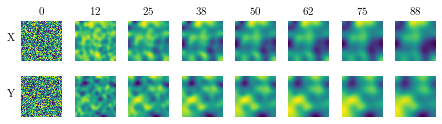

In [102]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.07, a1=a1, a2=a2)

In [103]:
correlation_coefficient, p_value = pearsonr(X.flatten(), Y.flatten())
correlation_coefficient, p_value 

(0.13142586660040478, 8.982500450084806e-40)

In [104]:
results_007 = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [105]:
results_007_L = run_GCCM_sampling(X, Y, lib_sizes, E=6, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


### moderate

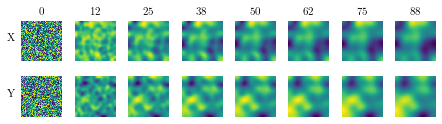

In [78]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.1, a1=a1, a2=a2, saveas='v1_c01_sim100.pdf')

In [79]:
correlation_coefficient, p_value = pearsonr(X.flatten(), Y.flatten())
correlation_coefficient, p_value 

(0.23323059080147246, 1.267832625697449e-123)

In [49]:
results_01 = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [80]:
results_01_L = run_GCCM_sampling(X, Y, lib_sizes, E=6, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


### strong

As processes become tightly coupled, each tends to become a good estimators of the others’ dynamics even though causation is unidirectional

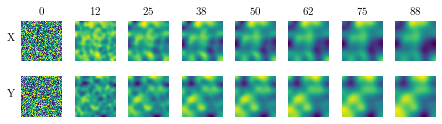

In [81]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.2, a1=a1, a2=a2)

In [82]:
correlation_coefficient, p_value = pearsonr(X.flatten(), Y.flatten())
correlation_coefficient, p_value 

(0.5552733156136214, 0.0)

In [51]:
results_02 = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [83]:
results_02_L = run_GCCM_sampling(X, Y, lib_sizes, E=6, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


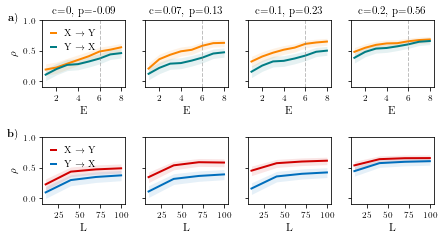

In [552]:
fig = plt.figure(figsize=(6.3, 3.5))

# Creating subplots using the functions
ax1 = make_Eplot(fig, 241, results_0, title=r'c=0, p=-0.09')
ax1.axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.text(-0.35, 1.0, r'$\textbf a)$', transform=ax1.transAxes, fontsize=11, horizontalalignment='center')
ax2 = make_Eplot(fig, 242, results_007, title=r'c=0.07, p=0.13', share=True)
ax2.axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2 = make_Eplot(fig, 243, results_01, title=r'c=0.1, p=0.23', share=True)
ax2.axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2 = make_Eplot(fig, 244, results_02, title=r'c=0.2, p=0.56', share=True)
ax2.axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)


ax1 = make_Lplot(fig, 245, results_0_L)
ax1.text(-0.35, 1.0, r'$\textbf b)$', transform=ax1.transAxes, fontsize=11, horizontalalignment='center')
ax2 = make_Lplot(fig, 246, results_007_L, share=True)
ax2 = make_Lplot(fig, 247, results_01_L, share=True)
ax2 = make_Lplot(fig, 248, results_02_L, share=True)

plt.tight_layout()
plt.savefig('plots/diffusion/v1_crange.pdf', bbox_inches='tight')

In [26]:
ts = [0,10,20,30,50,100]
cols_r = ['#f6cfc4', '#f5af9c', '#f08f75', '#e86d4f', '#dd472b', '#d00000']
cols_b = ['#cad8f5', '#adc2ea', '#8eacde', '#6e96d3', '#4982c7', '#006ebc']

0
x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding
10
x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding
20
x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding
30
x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding
50
x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding
100
x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


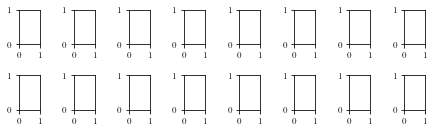

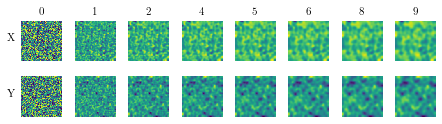

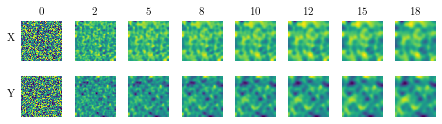

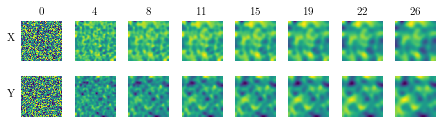

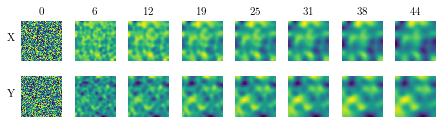

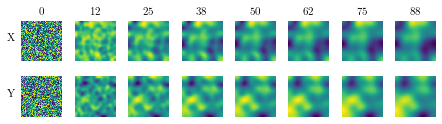

In [25]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.1, a1=a1, a2=a2)
results_01_trange = []
for t in [0,10,20,30,50,100]:
    print(t)
    X, Y = run_sim(X_rand, Y_rand, T=t, c=0.1, a1=a1, a2=a2)
    results = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)
    results_01_trange.append(results)

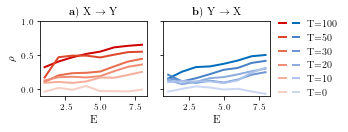

In [143]:
fig, ax = plt.subplots(1,2, figsize=(5,2), sharex=True, sharey=True)
l = []
for i in reversed(range(len(ts))):
    x_xmap_y, y_xmap_x = get_mean(results_01_trange[i], dims)
    p1, = ax[1].plot(dims, x_xmap_y,  c=cols_b[i],  lw=2, label = f'T=${ts[i]}$')
    p0, = ax[0].plot(dims, y_xmap_x,  c=cols_r[i],  lw=2, label = f'T=${ts[i]}$')
    l.append((p0,p1))
    
ax[0].set_ylim(-0.1,1)
ax[0].set_title(r'$\textbf a)$ X $\rightarrow$ Y')
ax[0].set_xlabel('E')
ax[0].set_ylabel(r'$\rho$')

ax[1].set_ylim(-0.1,1)
ax[1].set_title(r'$\textbf b)$ Y $\rightarrow$ X')
ax[1].set_xlabel('E')

legend = ax[1].legend(l, ['T=100','T=50','T=30','T=20','T=10','T=0'], 
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)}, 
                      loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

plt.tight_layout()
plt.savefig('plots/diffusion/v1_c01_trange.pdf', bbox_inches='tight')

# Version 2

In [144]:
np.random.seed(seed=54) #27: 0.15
X_rand = np.random.rand(size, size)
Y_rand = np.random.rand(size, size)

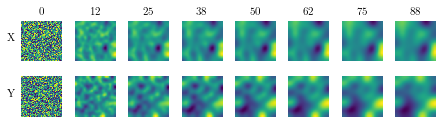

In [165]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.0, a1=a1, a2=a2, saveas='v2_c00_sim100.pdf')

In [166]:
correlation_coefficient, p_value = pearsonr(X.flatten(), Y.flatten())
correlation_coefficient, p_value 
# Essentially, this means that changes in the pixel values of one image are not strongly associated with 
#changes in the pixel values of the other image.

(0.04366606225070794, 1.2530700612817084e-05)

In [167]:
r2esults_0 = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [168]:
r2esults_0_L = run_GCCM_sampling(X, Y, lib_sizes, E=6, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


### weak

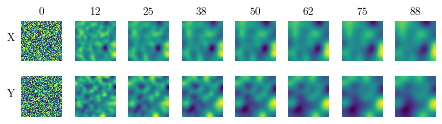

In [169]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.05, a1=a1, a2=a2)

In [170]:
correlation_coefficient, p_value = pearsonr(X.flatten(), Y.flatten())
correlation_coefficient, p_value 

(0.28503912570247014, 2.9958096155500922e-186)

In [171]:
r2esults_005 = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [172]:
r2esults_005_L = run_GCCM_sampling(X, Y, lib_sizes, E=6, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


### moderate

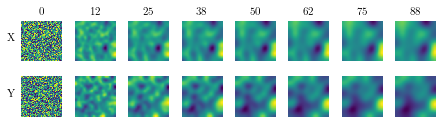

In [173]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.08, a1=a1, a2=a2, saveas='v2_c008_sim100.pdf')

In [174]:
correlation_coefficient, p_value = pearsonr(X.flatten(), Y.flatten())
correlation_coefficient, p_value 

(0.42192163485814693, 0.0)

In [175]:
r2esults_008 = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [176]:
r2esults_008_L = run_GCCM_sampling(X, Y, lib_sizes, E=6, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


### strong

As processes become tightly coupled, each tends to become a good estimators of the others’ dynamics even though causation is unidirectional

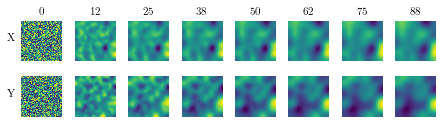

In [177]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.1, a1=a1, a2=a2)

In [178]:
correlation_coefficient, p_value = pearsonr(X.flatten(), Y.flatten())
correlation_coefficient, p_value 

(0.5047664463727346, 0.0)

In [179]:
r2esults_01 = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [180]:
r2esults_01_L = run_GCCM_sampling(X, Y, lib_sizes, E=6, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


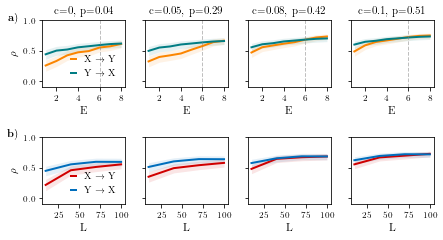

In [558]:
fig = plt.figure(figsize=(6.3, 3.5))

# Creating subplots using the functions
ax1 = make_Eplot(fig, 241, r2esults_0, title=r'c=0, p=0.04')
ax1.axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.text(-0.35, 1.0, r'$\textbf a)$', transform=ax1.transAxes, fontsize=11, horizontalalignment='center')
ax2 = make_Eplot(fig, 242, r2esults_005, title=r'c=0.05, p=0.29', share=True)
ax2.axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2 = make_Eplot(fig, 243, r2esults_008, title=r'c=0.08, p=0.42', share=True)
ax2.axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2 = make_Eplot(fig, 244, r2esults_01, title=r'c=0.1, p=0.51', share=True)
ax2.axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)


ax1 = make_Lplot(fig, 245, r2esults_0_L)
ax1.text(-0.35, 1.0, r'$\textbf b)$', transform=ax1.transAxes, fontsize=11, horizontalalignment='center')
ax2 = make_Lplot(fig, 246, r2esults_005_L, share=True)
ax2 = make_Lplot(fig, 247, r2esults_008_L, share=True)
ax2 = make_Lplot(fig, 248, r2esults_01_L, share=True)

plt.tight_layout()
plt.savefig('plots/diffusion/v2_crange.pdf', bbox_inches='tight')

0
x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding
10
x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding
20
x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding
30
x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding
50
x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding
100
x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


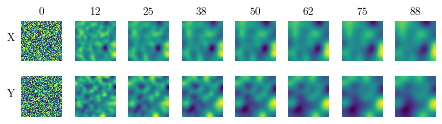

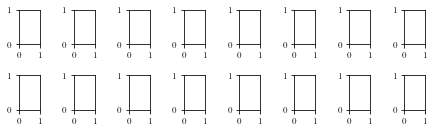

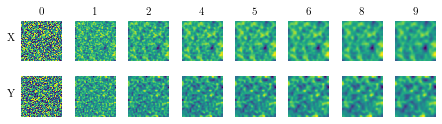

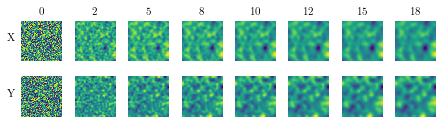

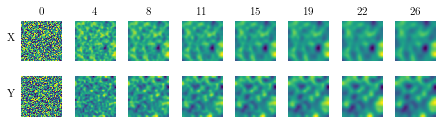

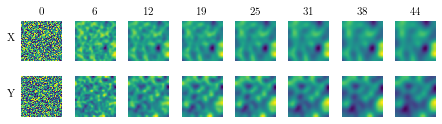

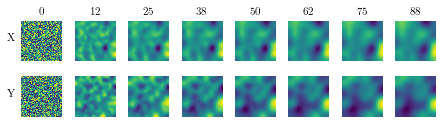

In [181]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.05, a1=a1, a2=a2)
r2esults_005_trange = []
for t in [0,10,20,30,50,100]:
    print(t)
    X, Y = run_sim(X_rand, Y_rand, T=t, c=0.1, a1=a1, a2=a2)
    r2esults = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)
    r2esults_005_trange.append(r2esults)

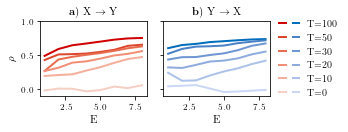

In [199]:
fig, ax = plt.subplots(1,2, figsize=(5,2), sharex=True, sharey=True)
l = []
for i in reversed(range(len(ts))):
    x_xmap_y, y_xmap_x = get_mean(r2esults_005_trange[i], dims)
    p1, = ax[1].plot(dims, x_xmap_y,  c=cols_b[i],  lw=2, label = f'T=${ts[i]}$')
    p0, = ax[0].plot(dims, y_xmap_x,  c=cols_r[i],  lw=2, label = f'T=${ts[i]}$')
    l.append((p0,p1))
    
ax[0].set_ylim(-0.1,1)
ax[0].set_title(r'$\textbf a)$ X $\rightarrow$ Y')
ax[0].set_xlabel('E')
ax[0].set_ylabel(r'$\rho$')

ax[1].set_ylim(-0.1,1)
ax[1].set_title(r'$\textbf b)$ Y $\rightarrow$ X')
ax[1].set_xlabel('E')

legend = ax[1].legend(l, ['T=100','T=50','T=30','T=20','T=10','T=0'], 
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)}, 
                      loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

plt.tight_layout()
plt.savefig('plots/diffusion/v2_c005_trange.pdf', bbox_inches='tight')

# Diffusion parameter a

## version 1

In [226]:
np.random.seed(seed=3)
X_rand = np.random.rand(size, size)
Y_rand = np.random.rand(size, size)

In [227]:
a1 = 2.8e-4  # X
a2 = 1.4e-4  # Y

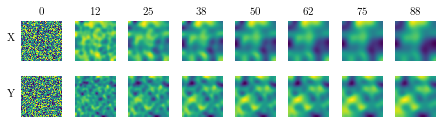

In [228]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.1, a1=a1, a2=a2)

In [229]:
correlation_coefficient, p_value = pearsonr(X.flatten(), Y.flatten())
correlation_coefficient, p_value 

(0.17983977718042032, 1.8567667148205588e-73)

In [230]:
rdesults_01 = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [231]:
rdesults_01_L = run_GCCM_sampling(X, Y, lib_sizes, E=6, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


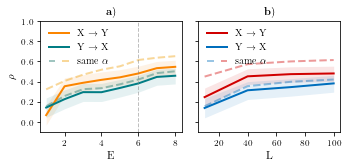

In [534]:
fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharey=True)

x_xmap_y, y_xmap_x = get_mean(results_01, dims)
p1,= ax[0].plot(dims, x_xmap_y, '--', c='#136F63', alpha=0.4, lw=2)
p2,= ax[0].plot(dims, y_xmap_x, '--', c='#EE9B00', alpha=0.4, lw=2)

x_xmap_y, y_xmap_x = get_mean(rdesults_01, dims)
xy_u, xy_l, yx_u, yx_l = get_interval(rdesults_01, dims)
p3,=ax[0].plot(dims, y_xmap_x,  c='#FB8500', lw=2, label = r'X $\rightarrow$ Y')
ax[0].fill_between(dims, yx_l, yx_u, color='#FB8500', alpha=0.1, lw=0)
p4,=ax[0].plot(dims, x_xmap_y,  c='#017D84', lw=2, label = r'Y $\rightarrow$ X' )
ax[0].fill_between(dims, xy_l, xy_u, color='#017D84', alpha=0.1, lw=0)
ax[0].axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)


ax[0].set_ylim(-0.1,1)
ax[0].set_title(r'$\textbf a)$')
ax[0].set_xlabel('E')
#ax[0].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
ax[0].set_ylabel(r'$\rho$')
legend = ax[0].legend([p3, p4, (p1, p2)], [r'X $\rightarrow$ Y', r'Y $\rightarrow$ X', r'same $\alpha$'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)},frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

x_xmap_y, y_xmap_x = get_mean(results_01_L, lib_sizes)
p1,= ax[1].plot(lib_sizes, x_xmap_y, '--', c='#006EBC', alpha=0.4, lw=2)
p2,= ax[1].plot(lib_sizes, y_xmap_x, '--', c='#D00000', alpha=0.4, lw=2)

x_xmap_y, y_xmap_x = get_mean(rdesults_01_L, lib_sizes)
xy_u, xy_l, yx_u, yx_l = get_interval(rdesults_01_L, lib_sizes)
p3, = ax[1].plot(lib_sizes, y_xmap_x,  c='#D00000', lw=2, label = r'X $\rightarrow$ Y')
ax[1].fill_between(lib_sizes, yx_l, yx_u, color='#D00000', alpha=0.1, lw=0)
p4,=ax[1].plot(lib_sizes, x_xmap_y,  c='#006EBC', lw=2, label = r'Y $\rightarrow$ X' )
ax[1].fill_between(lib_sizes, xy_l, xy_u, color='#006EBC', alpha=0.1, lw=0)

ax[1].set_title(r'$\textbf b)$')
ax[1].set_xlabel('L')
#ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
legend = ax[1].legend([p3, p4, (p1, p2)], [r'X $\rightarrow$ Y', r'Y $\rightarrow$ X', r'same $\alpha$'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)}, frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

plt.tight_layout()
plt.savefig('plots/diffusion/v1_c01_diffhalf.pdf', bbox_inches='tight')

In [233]:
a1 = 2.8e-4  # X
a2 = 0.7e-4  # Y

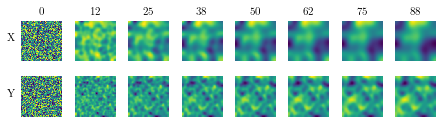

In [234]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.1, a1=a1, a2=a2)

In [235]:
correlation_coefficient, p_value = pearsonr(X.flatten(), Y.flatten())
correlation_coefficient, p_value 

(0.12357232986859569, 2.509320734030249e-35)

In [236]:
rddesults_01 = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [237]:
rddesults_01_L = run_GCCM_sampling(X, Y, lib_sizes, E=6, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


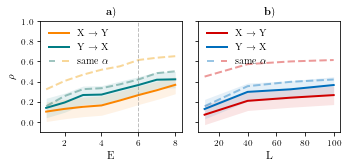

In [535]:
fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharey=True)

x_xmap_y, y_xmap_x = get_mean(results_01, dims)
p1,= ax[0].plot(dims, x_xmap_y, '--', c='#136F63', alpha=0.4, lw=2)
p2,= ax[0].plot(dims, y_xmap_x, '--', c='#EE9B00', alpha=0.4, lw=2)

x_xmap_y, y_xmap_x = get_mean(rddesults_01, dims)
xy_u, xy_l, yx_u, yx_l = get_interval(rddesults_01, dims)
p3,=ax[0].plot(dims, y_xmap_x,  c='#FB8500', lw=2, label = r'X $\rightarrow$ Y')
ax[0].fill_between(dims, yx_l, yx_u, color='#FB8500', alpha=0.1, lw=0)
p4,=ax[0].plot(dims, x_xmap_y,  c='#017D84', lw=2, label = r'Y $\rightarrow$ X' )
ax[0].fill_between(dims, xy_l, xy_u, color='#017D84', alpha=0.1, lw=0)
ax[0].axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax[0].set_ylim(-0.1,1)
ax[0].set_title(r'$\textbf a)$')
ax[0].set_xlabel('E')
#ax[0].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
ax[0].set_ylabel(r'$\rho$')
legend = ax[0].legend([p3, p4, (p1, p2)], [r'X $\rightarrow$ Y', r'Y $\rightarrow$ X', r'same $\alpha$'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)}, frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

x_xmap_y, y_xmap_x = get_mean(results_01_L, lib_sizes)
p1,= ax[1].plot(lib_sizes, x_xmap_y, '--', c='#006EBC', alpha=0.4, lw=2)
p2,= ax[1].plot(lib_sizes, y_xmap_x, '--', c='#D00000', alpha=0.4, lw=2)

x_xmap_y, y_xmap_x = get_mean(rddesults_01_L, lib_sizes)
xy_u, xy_l, yx_u, yx_l = get_interval(rddesults_01_L, lib_sizes)
p3, = ax[1].plot(lib_sizes, y_xmap_x,  c='#D00000', lw=2, label = r'X $\rightarrow$ Y')
ax[1].fill_between(lib_sizes, yx_l, yx_u, color='#D00000', alpha=0.1, lw=0)
p4,=ax[1].plot(lib_sizes, x_xmap_y,  c='#006EBC', lw=2, label = r'Y $\rightarrow$ X' )
ax[1].fill_between(lib_sizes, xy_l, xy_u, color='#006EBC', alpha=0.1, lw=0)

ax[1].set_title(r'$\textbf b)$')
ax[1].set_xlabel('L')
#ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
legend = ax[1].legend([p3, p4, (p1, p2)], [r'X $\rightarrow$ Y', r'Y $\rightarrow$ X', r'same $\alpha$'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)},frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

plt.tight_layout()
plt.savefig('plots/diffusion/v1_c01_diffquart.pdf', bbox_inches='tight')

## version 2

In [201]:
np.random.seed(seed=54)
X_rand = np.random.rand(size, size)
Y_rand = np.random.rand(size, size)

In [200]:
a1 = 1.4e-4  # X
a2 = 2.8e-4  # Y

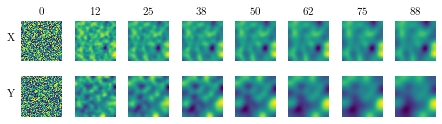

In [202]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.05, a1=a1, a2=a2)

In [203]:
correlation_coefficient, p_value = pearsonr(X.flatten(), Y.flatten())
correlation_coefficient, p_value 

(0.30786315418640064, 1.689732862310002e-218)

In [204]:
r2desults_005 = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [205]:
r2desults_005_L = run_GCCM_sampling(X, Y, lib_sizes, E=6, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


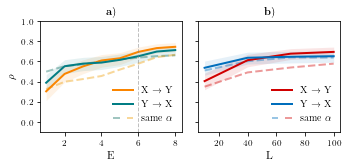

In [536]:
fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharey=True)

x_xmap_y, y_xmap_x = get_mean(r2esults_005, dims)
p1,= ax[0].plot(dims, x_xmap_y, '--', c='#136F63', alpha=0.4, lw=2)
p2,= ax[0].plot(dims, y_xmap_x, '--', c='#EE9B00', alpha=0.4, lw=2)

x_xmap_y, y_xmap_x = get_mean(r2desults_005, dims)
xy_u, xy_l, yx_u, yx_l = get_interval(r2desults_005, dims)
p3,=ax[0].plot(dims, y_xmap_x,  c='#FB8500', lw=2, label = r'X $\rightarrow$ Y')
ax[0].fill_between(dims, yx_l, yx_u, color='#FB8500', alpha=0.1, lw=0)
p4,=ax[0].plot(dims, x_xmap_y,  c='#017D84', lw=2, label = r'Y $\rightarrow$ X' )
ax[0].fill_between(dims, xy_l, xy_u, color='#017D84', alpha=0.1, lw=0)
ax[0].axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax[0].set_ylim(-0.1,1)
ax[0].set_title(r'$\textbf a)$')
ax[0].set_xlabel('E')
#ax[0].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
ax[0].set_ylabel(r'$\rho$')
legend = ax[0].legend([p3, p4, (p1, p2)], [r'X $\rightarrow$ Y', r'Y $\rightarrow$ X', r'same $\alpha$'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)},
                    frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

x_xmap_y, y_xmap_x = get_mean(r2esults_005_L, lib_sizes)
p1,= ax[1].plot(lib_sizes, x_xmap_y, '--', c='#006EBC', alpha=0.4, lw=2)
p2,= ax[1].plot(lib_sizes, y_xmap_x, '--', c='#D00000', alpha=0.4, lw=2)

x_xmap_y, y_xmap_x = get_mean(r2desults_005_L, lib_sizes)
xy_u, xy_l, yx_u, yx_l = get_interval(r2desults_005_L, lib_sizes)
p3, = ax[1].plot(lib_sizes, y_xmap_x,  c='#D00000', lw=2, label = r'X $\rightarrow$ Y')
ax[1].fill_between(lib_sizes, yx_l, yx_u, color='#D00000', alpha=0.1, lw=0)
p4,=ax[1].plot(lib_sizes, x_xmap_y,  c='#006EBC', lw=2, label = r'Y $\rightarrow$ X' )
ax[1].fill_between(lib_sizes, xy_l, xy_u, color='#006EBC', alpha=0.1, lw=0)

ax[1].set_title(r'$\textbf b)$')
ax[1].set_xlabel('L')
#ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
legend = ax[1].legend([p3, p4, (p1, p2)], [r'X $\rightarrow$ Y', r'Y $\rightarrow$ X', r'same $\alpha$'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)},
                     frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

plt.tight_layout()
plt.savefig('plots/diffusion/v2_c005_diffhalf.pdf', bbox_inches='tight')

In [217]:
a1 = 0.7e-4  # X
a2 = 2.8e-4  # Y

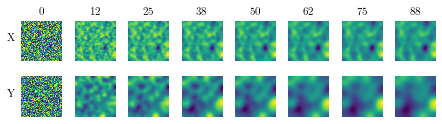

In [218]:
X, Y = run_sim(X_rand, Y_rand, T=100, c=0.05, a1=a1, a2=a2)

In [219]:
correlation_coefficient, p_value = pearsonr(X.flatten(), Y.flatten())
correlation_coefficient, p_value 

(0.3152798399613768, 1.2727537440356683e-229)

In [220]:
r2ddesults_005 = run_optEmbedding_sampling(X, Y, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [221]:
r2ddesults_005_L = run_GCCM_sampling(X, Y, lib_sizes, E=6, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


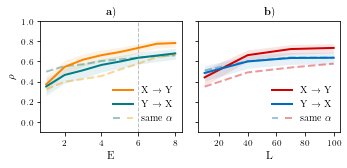

In [537]:
fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharey=True)

x_xmap_y, y_xmap_x = get_mean(r2esults_005, dims)
p1,= ax[0].plot(dims, x_xmap_y, '--', c='#136F63', alpha=0.4, lw=2)
p2,= ax[0].plot(dims, y_xmap_x, '--', c='#EE9B00', alpha=0.4, lw=2)

x_xmap_y, y_xmap_x = get_mean(r2ddesults_005, dims)
xy_u, xy_l, yx_u, yx_l = get_interval(r2ddesults_005, dims)
p3,=ax[0].plot(dims, y_xmap_x,  c='#FB8500', lw=2, label = r'X $\rightarrow$ Y')
ax[0].fill_between(dims, yx_l, yx_u, color='#FB8500', alpha=0.1, lw=0)
p4,=ax[0].plot(dims, x_xmap_y,  c='#017D84', lw=2, label = r'Y $\rightarrow$ X' )
ax[0].fill_between(dims, xy_l, xy_u, color='#017D84', alpha=0.1, lw=0)
ax[0].axvline(x=6, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax[0].set_ylim(-0.1,1)
ax[0].set_title(r'$\textbf a)$')
ax[0].set_xlabel('E')
#ax[0].xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
ax[0].set_ylabel(r'$\rho$')
legend = ax[0].legend([p3, p4, (p1, p2)], [r'X $\rightarrow$ Y', r'Y $\rightarrow$ X', r'same $\alpha$'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)},
                     loc='lower right', frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

x_xmap_y, y_xmap_x = get_mean(r2esults_005_L, lib_sizes)
p1,= ax[1].plot(lib_sizes, x_xmap_y, '--', c='#006EBC', alpha=0.4, lw=2)
p2,= ax[1].plot(lib_sizes, y_xmap_x, '--', c='#D00000', alpha=0.4, lw=2)

x_xmap_y, y_xmap_x = get_mean(r2ddesults_005_L, lib_sizes)
xy_u, xy_l, yx_u, yx_l = get_interval(r2ddesults_005_L, lib_sizes)
p3, = ax[1].plot(lib_sizes, y_xmap_x,  c='#D00000', lw=2, label = r'X $\rightarrow$ Y')
ax[1].fill_between(lib_sizes, yx_l, yx_u, color='#D00000', alpha=0.1, lw=0)
p4, = ax[1].plot(lib_sizes, x_xmap_y,  c='#006EBC', lw=2, label = r'Y $\rightarrow$ X' )
ax[1].fill_between(lib_sizes, xy_l, xy_u, color='#006EBC', alpha=0.1, lw=0)

ax[1].set_title(r'$\textbf b)$')
ax[1].set_xlabel('L')
#ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
legend = ax[1].legend([p3, p4, (p1, p2)], [r'X $\rightarrow$ Y', r'Y $\rightarrow$ X', r'same $\alpha$'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)},
                     loc='lower right', frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

plt.tight_layout()
plt.savefig('plots/diffusion/v2_c005_diffquart.pdf', bbox_inches='tight')

# Initialisation

## no coupling

In [457]:
np.random.seed(seed=18)
a1 = 2.8e-4
a2 = 2.8e-4

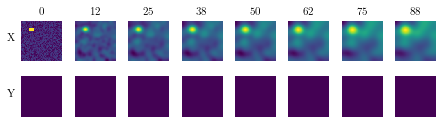

In [461]:
Y_fix = np.full((size, size), 0.5)
X_loc = np.random.rand(size, size)

top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_loc[top_row:bottom_row+1, left_col:right_col+1] = 5

X0, Y0 = run_sim(X_loc, Y_fix, T=100, c=0, a1=a1, a2=a2)

In [462]:
correlation_coefficient, p_value = pearsonr(X0.flatten(), Y0.flatten())
correlation_coefficient, p_value 

(nan, nan)

In [463]:
iresults_0 = run_optEmbedding_sampling(X0, Y0, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [471]:
iresults_0_L = run_GCCM_sampling(X0, Y0, lib_sizes, E=2, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


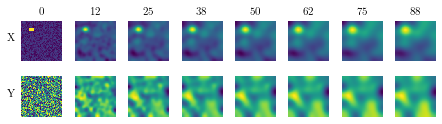

In [465]:
np.random.seed(seed=18)
Y_rand = np.random.rand(size, size)
X_loc = np.random.rand(size, size)

top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_loc[top_row:bottom_row+1, left_col:right_col+1] = 5

X0r, Y0r = run_sim(X_loc, Y_rand, T=100, c=0, a1=a1, a2=a2)

In [466]:
correlation_coefficient, p_value = pearsonr(X0r.flatten(), Y_rand.flatten())
correlation_coefficient, p_value 

(-0.0025362153818249784, 0.7998121364286642)

In [467]:
rriresults_0 = run_optEmbedding_sampling(X0r, Y_rand, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [468]:
rriresults_0_L = run_GCCM_sampling(X0r, Y_rand, lib_sizes, E=3, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


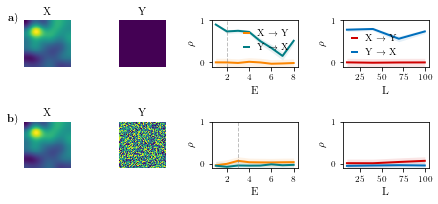

In [472]:
fig = plt.figure(figsize=(6.3, 3))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1.75, 1.75])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
show_patterns(X0, ax=ax1)
ax1.set_title('X')
ax1.text(-0.25, 1, r'$\textbf a)$', transform=ax1.transAxes, fontsize=11, horizontalalignment='center')
show_patterns(Y0, ax=ax2)
ax2.set_title('Y')
ax3 = make_Eplot(fig, gs[0, 2], iresults_0, title=r' ')
ax3.axvline(x=2, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax4 = make_Lplot(fig, gs[0, 3], iresults_0_L, title=r' ')

ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
show_patterns(X0r, ax=ax1)
ax1.set_title('X')
ax1.text(-0.25, 1, r'$\textbf b)$', transform=ax1.transAxes, fontsize=11, horizontalalignment='center')
show_patterns(Y_rand, ax=ax2)
ax2.set_title('Y')
ax3 = make_Eplot(fig, gs[1, 2], rriresults_0, title=r' ')
ax3.axvline(x=3, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax4 = make_Lplot(fig, gs[1, 3], rriresults_0_L, title=r' ')
ax3.get_legend().remove()
ax4.get_legend().remove()

plt.tight_layout()
plt.savefig('plots/diffusion/init_c0.pdf', bbox_inches='tight')

## coupling

### constant

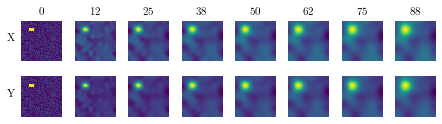

In [473]:
np.random.seed(seed=18)
Y_fix = np.full((size, size), 0.5)
X_loc = np.random.rand(size, size)

top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_loc[top_row:bottom_row+1, left_col:right_col+1] = 5

X01, Y01 = run_sim(X_loc, Y_fix, T=100, c=0.01, a1=a1, a2=a2)

In [474]:
correlation_coefficient, p_value = pearsonr(X01.flatten(), Y01.flatten())
correlation_coefficient, p_value 

(0.9969736070772033, 0.0)

In [475]:
iresults_01 = run_optEmbedding_sampling(X01, Y01, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [476]:
iresults_01_L = run_GCCM_sampling(X01, Y01, lib_sizes, E=5, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


### random

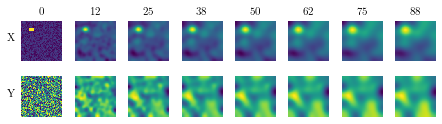

In [465]:
np.random.seed(seed=18)
Y_rand = np.random.rand(size, size)
X_loc = np.random.rand(size, size)

top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_loc[top_row:bottom_row+1, left_col:right_col+1] = 5

X0r, Y0r = run_sim(X_loc, Y_rand, T=100, c=0, a1=a1, a2=a2)

In [491]:
correlation_coefficient, p_value = pearsonr(X0r.flatten(), Y0r.flatten())
correlation_coefficient, p_value 

(-0.20525714598350125, 1.3775892046499004e-95)

In [492]:
riresults_0 = run_optEmbedding_sampling(X0r, Y0r, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [493]:
riresults_0_L = run_GCCM_sampling(X0r, Y0r, lib_sizes, E=3, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


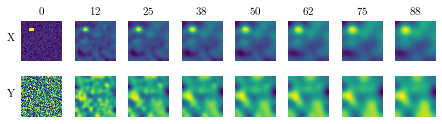

In [478]:
np.random.seed(seed=18)
Y_rand = np.random.rand(size, size)
X_loc = np.random.rand(size, size)

top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_loc[top_row:bottom_row+1, left_col:right_col+1] = 5

X001r, Y001r = run_sim(X_loc, Y_rand, T=100, c=0.01, a1=a1, a2=a2)

In [479]:
correlation_coefficient, p_value = pearsonr(X001r.flatten(), Y001r.flatten())
correlation_coefficient, p_value 

(-0.1223559784151791, 1.1566494692031876e-34)

In [480]:
riresults_001 = run_optEmbedding_sampling(X001r, Y001r, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [481]:
riresults_001_L = run_GCCM_sampling(X001r, Y001r, lib_sizes, E=5, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


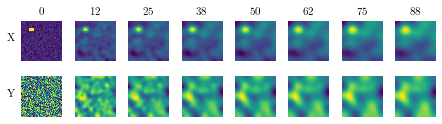

In [482]:
np.random.seed(seed=18)
Y_rand = np.random.rand(size, size)
X_loc = np.random.rand(size, size)

top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_loc[top_row:bottom_row+1, left_col:right_col+1] = 5

X005r, Y005r = run_sim(X_loc, Y_rand, T=100, c=0.05, a1=a1, a2=a2)

In [483]:
correlation_coefficient, p_value = pearsonr(X005r.flatten(), Y005r.flatten())
correlation_coefficient, p_value 

(0.2330212461011837, 2.125878490541142e-123)

In [484]:
riresults_005 = run_optEmbedding_sampling(X005r, Y005r, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [485]:
riresults_005_L = run_GCCM_sampling(X005r, Y005r, lib_sizes, E=5, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


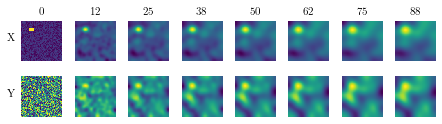

In [495]:
np.random.seed(seed=18)
Y_rand = np.random.rand(size, size)
X_loc = np.random.rand(size, size)

top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_loc[top_row:bottom_row+1, left_col:right_col+1] = 5

X01r, Y01r = run_sim(X_loc, Y_rand, T=100, c=0.1, a1=a1, a2=a2)

In [496]:
correlation_coefficient, p_value = pearsonr(X01r.flatten(), Y01r.flatten())
correlation_coefficient, p_value 

(0.5908635332994244, 0.0)

In [497]:
riresults_01 = run_optEmbedding_sampling(X01r, Y01r, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [498]:
riresults_01_L = run_GCCM_sampling(X01r, Y01r, lib_sizes, E=5, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


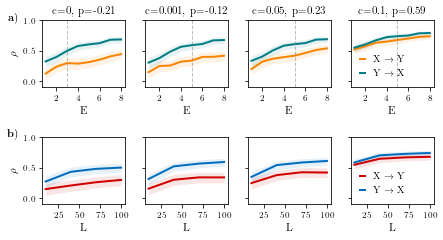

In [557]:
fig = plt.figure(figsize=(6.3, 3.5))

# Creating subplots using the functions
ax1 = make_Eplot(fig, 241, riresults_0, title=r'c=0, p=-0.21')
ax1.axvline(x=3, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.text(-0.35, 1.0, r'$\textbf a)$', transform=ax1.transAxes, fontsize=11, horizontalalignment='center')
ax1.get_legend().remove()
ax2 = make_Eplot(fig, 242, riresults_001, title=r'c=0.001, p=-0.12', share=True)
ax2.axvline(x=5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2 = make_Eplot(fig, 243, riresults_005, title=r'c=0.05, p=0.23', share=True)
ax2.axvline(x=5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2 = make_Eplot(fig, 244, riresults_01, title=r'c=0.1, p=0.59', share=False)
ax2.axvline(x=5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_yticklabels([])
ax2.set_ylabel('')


ax1 = make_Lplot(fig, 245, riresults_0_L)
ax1.get_legend().remove()
ax1.text(-0.35, 1.0, r'$\textbf b)$', transform=ax1.transAxes, fontsize=11, horizontalalignment='center')
ax2 = make_Lplot(fig, 246, riresults_001_L, share=True)
ax2 = make_Lplot(fig, 247, riresults_005_L, share=True)
ax2 = make_Lplot(fig, 248, riresults_01_L, share=False)
ax2.set_yticklabels([])
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig('plots/diffusion/init_crange.pdf', bbox_inches='tight')

## short

### constant

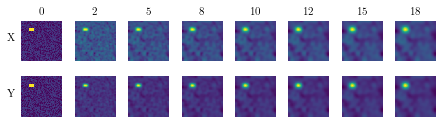

In [488]:
np.random.seed(seed=18)
Y_fix = np.full((size, size), 0.5)
X_loc = np.random.rand(size, size)

top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_loc[top_row:bottom_row+1, left_col:right_col+1] = 5

sX01, sY01 = run_sim(X_loc, Y_fix, T=20, c=0.01, a1=a1, a2=a2)

In [489]:
correlation_coefficient, p_value = pearsonr(sX01.flatten(), sY01.flatten())
correlation_coefficient, p_value 

(0.9901124809543549, 0.0)

### random

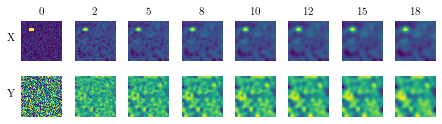

In [490]:
np.random.seed(seed=18)
Y_rand = np.random.rand(size, size)
X_loc = np.random.rand(size, size)

top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_loc[top_row:bottom_row+1, left_col:right_col+1] = 5

sX0r, sY0r = run_sim(X_loc, Y_rand, T=20, c=0, a1=a1, a2=a2)

In [501]:
correlation_coefficient, p_value = pearsonr(sX0r.flatten(), sY0r.flatten())
correlation_coefficient, p_value 

(-0.07144986778331361, 8.475522255201702e-13)

In [503]:
sriresults_0 = run_optEmbedding_sampling(sX0r, sY0r, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [504]:
sriresults_0_L = run_GCCM_sampling(sX0r, sY0r, lib_sizes, E=3, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


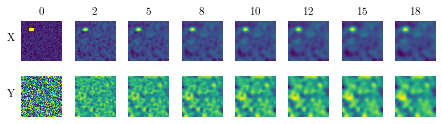

In [509]:
np.random.seed(seed=18)
Y_rand = np.random.rand(size, size)
X_loc = np.random.rand(size, size)

top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_loc[top_row:bottom_row+1, left_col:right_col+1] = 5

sX005r, sY005r = run_sim(X_loc, Y_rand, T=20, c=0.05, a1=a1, a2=a2)

In [510]:
correlation_coefficient, p_value = pearsonr(sX005r.flatten(), sY005r.flatten())
correlation_coefficient, p_value 

(0.18663377536244266, 4.564394888408782e-79)

In [511]:
sriresults_005 = run_optEmbedding_sampling(sX005r, sY005r, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [530]:
sriresults_005_L = run_GCCM_sampling(sX005r, sY005r, lib_sizes, E=4, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


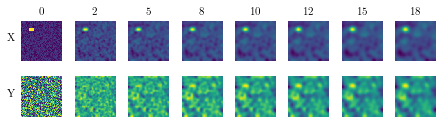

In [513]:
np.random.seed(seed=18)
Y_rand = np.random.rand(size, size)
X_loc = np.random.rand(size, size)

top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_loc[top_row:bottom_row+1, left_col:right_col+1] = 5

sX01r, sY01r = run_sim(X_loc, Y_rand, T=20, c=0.1, a1=a1, a2=a2)

In [514]:
correlation_coefficient, p_value = pearsonr(sX01r.flatten(), sY01r.flatten())
correlation_coefficient, p_value 

(0.41958431108767114, 0.0)

In [515]:
sriresults_01 = run_optEmbedding_sampling(sX01r, sY01r, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [516]:
sriresults_01_L = run_GCCM_sampling(sX005r, sY01r, lib_sizes, E=5, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


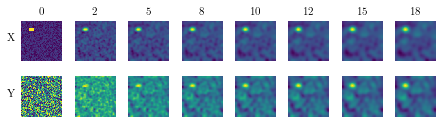

In [524]:
np.random.seed(seed=18)
Y_rand = np.random.rand(size, size)
X_loc = np.random.rand(size, size)

top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_loc[top_row:bottom_row+1, left_col:right_col+1] = 5

sX02r, sY02r = run_sim(X_loc, Y_rand, T=20, c=0.2, a1=a1, a2=a2)

In [525]:
correlation_coefficient, p_value = pearsonr(sX02r.flatten(), sY02r.flatten())
correlation_coefficient, p_value 

(0.7191729942056282, 0.0)

In [526]:
sriresults_02 = run_optEmbedding_sampling(sX02r, sY02r, lib_size, dims, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


In [527]:
sriresults_02_L = run_GCCM_sampling(sX02r, sY02r, lib_sizes, E=5, cores=6)

x_xmap_y
Constructing embedding
y_xmap_x
Constructing embedding


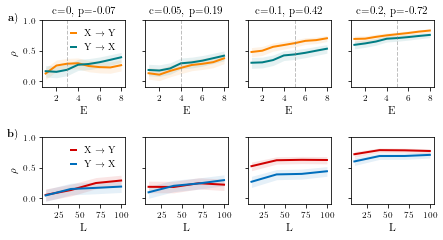

In [559]:
fig = plt.figure(figsize=(6.3, 3.5))

# Creating subplots using the functions
ax1 = make_Eplot(fig, 241, sriresults_0, title=r'c=0, p=-0.07')
ax1.axvline(x=3, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.text(-0.35, 1.0, r'$\textbf a)$', transform=ax1.transAxes, fontsize=11, horizontalalignment='center')
ax2 = make_Eplot(fig, 242, sriresults_005, title=r'c=0.05, p=0.19', share=True)
ax2.axvline(x=4, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2 = make_Eplot(fig, 243, sriresults_01, title=r'c=0.1, p=0.42', share=True)
ax2.axvline(x=5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2 = make_Eplot(fig, 244, sriresults_02, title=r'c=0.2, p=-0.72', share=True)
ax2.axvline(x=5, color='gray', linestyle='--', linewidth=1, alpha=0.5)


ax1 = make_Lplot(fig, 245, sriresults_0_L)
ax1.text(-0.35, 1.0, r'$\textbf b)$', transform=ax1.transAxes, fontsize=11, horizontalalignment='center')
ax2 = make_Lplot(fig, 246, sriresults_005_L, share=True)
ax2 = make_Lplot(fig, 247, sriresults_01_L, share=True)
ax2 = make_Lplot(fig, 248, sriresults_02_L, share=True)

plt.tight_layout()
plt.savefig('plots/diffusion/init_crange_short.pdf', bbox_inches='tight')

# Cofounder Z



$$ \frac{\partial z}{\partial t} = d_1 \Delta z - z^2 $$

$$ \frac{\partial x}{\partial t} = d_0 \Delta x - x^2 + c_1z $$

$$ \frac{\partial y}{\partial t} = d_0 \Delta y - y^2 + c_0 ~xy + c_2z $$

In [106]:
def plot_confound(X, Y, Z, T, c0, cx, cy, a, b):
    
    dt = .001  # time step, 
    n = int(T / dt)  # number of iterations

    fig, axes = plt.subplots(3,9, figsize=(12, 4))
    step_plot = n // 9
    # We simulate the PDE with the finite difference
    # method.
    for i in range(n):
        # We compute the Laplacian of u and v.
        deltaZ = laplacian(Z)
        deltaX = laplacian(X)
        deltaY = laplacian(Y)
        # We take the values of u and v inside the grid.
        Zc = Z[1:-1, 1:-1]
        Xc = X[1:-1, 1:-1]
        Yc = Y[1:-1, 1:-1]
        
        # We update the variables.
        Z[1:-1, 1:-1], X[1:-1, 1:-1], Y[1:-1, 1:-1] = \
            Zc + dt * (b * deltaZ - Zc**2),\
            Xc + dt * (a * deltaX - Xc**2 + cx*Zc),\
            Yc + dt * (a * deltaY - Yc**2 + c0 * Xc * Yc + cy*Zc)
        
        # Neumann conditions: derivatives at the edges
        # are null.
        for B in (X, Y, Z):
            B[0, :] = B[1, :]
            B[-1, :] = B[-2, :]
            B[:, 0] = B[:, 1]
            B[:, -1] = B[:, -2]
    
        # We plot the state of the system at
        # 9 different times.
        if i % step_plot == 0 and i < 9 * step_plot:
            ax = axes[0, i // step_plot]
            show_patterns(Z, ax=ax)
            ax.set_title(f'Z $t={i * dt:.2f}$')
            
            ax = axes[1, i // step_plot]
            show_patterns(X, ax=ax)
            ax.set_title(f'X $t={i * dt:.2f}$')
            
            ax = axes[2, i // step_plot]
            show_patterns(Y, ax=ax)
            ax.set_title(f'Y $t={i * dt:.2f}$')
    plt.tight_layout()

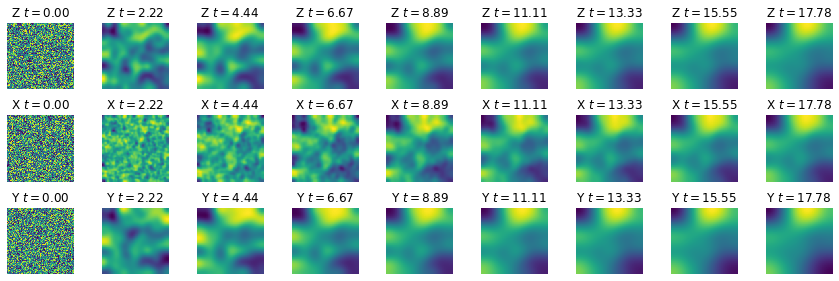

In [168]:
Z_rand = np.random.rand(size, size)
X_rand = np.random.rand(size, size)
Y_rand = np.random.rand(size, size)

plot_confound(X_rand, Y_rand, Z_rand, T=20, c0=0, cx=0.4, cy=0.4, a=2.64e-3, b=2.8e-4)

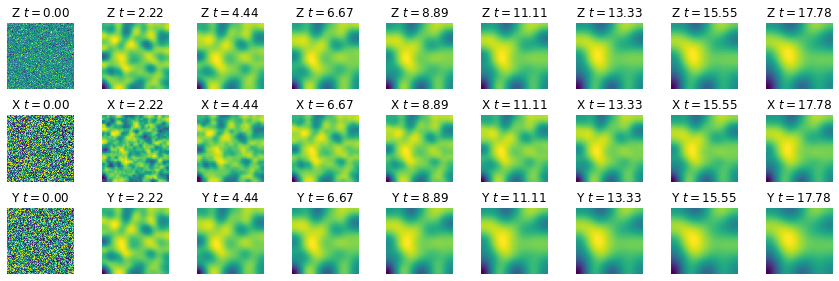

In [169]:
Z_rand = np.random.normal(1,2,(size, size))
X_rand = np.random.rand(size, size)
Y_rand = np.random.rand(size, size)

plot_confound(X_rand, Y_rand, Z_rand, T=20, c0=0, cx=0.4, cy=0.4, dz=2.64e-3, dx=2.8e-4, dy=5e-3)

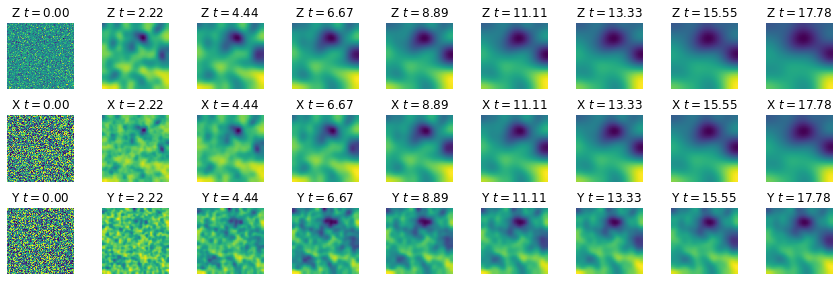

In [172]:
Z_rand = np.random.normal(1,2,(size, size))
X_rand = np.random.rand(size, size)
Y_rand = np.random.rand(size, size)

plot_confound(X_rand, Y_rand, Z_rand, T=20, c0=0, cx=0.8, cy=0.1, dz=2.64e-3, dx=2.8e-4, dy=2.8e-4)

- what is strong, what is weak coupling? c
- when is burn in done? T
- initialize X and Y differently?